In [2]:
import os
from pathlib import Path
from astropy.io import fits
import numpy as np
import pandas as pd

#pad naar de betreffende metingen, deze moet veranderd worden
path = "C:/Users/Arnau/Documents/NS Practicum 2/Zonnefysica Experiment/map/"
files =  [ p for p in Path(path).glob('*.fit') ]

data_dict = dict()
for file in files:
    data_dict[os.path.basename(file)] = fits.getdata(file)

data_headers = dict()
for x in data_dict.keys():
    data_headers[x] = fits.getheader(path + x)

In [3]:
def import_files(path, filename):
    '''
    Import files in the syntax that I used in the notebook. That is, choose the path that contains
    all the fit files, then for the filename choose something like bias* to obtain all bias files
    as a dictionary that can be accessed by filename 
    '''
    files =  [ p for p in Path(path).glob(filename) ]
    file_dict = dict()
    for file in files:
        file_dict[os.path.basename(file)] = fits.getdata(file) # key of the dict is the filename.

    headers_dict = dict()
    for x in file_dict.keys():
        headers_dict[x] = fits.getheader(path + x)

    return file_dict, headers_dict 

bias_dict, bias_headers = import_files(
    path="C:/Users/Arnau/Documents/NS Practicum 2/Zonnefysica Experiment/map/",
    filename="bias*"
)
bias_dict

{'bias-001.fit': array([[264, 279, 264, ..., 259, 257, 244],
        [266, 287, 275, ..., 279, 280, 277],
        [254, 279, 253, ..., 284, 263, 299],
        ...,
        [260, 276, 271, ..., 273, 269, 262],
        [265, 274, 246, ..., 288, 270, 266],
        [247, 277, 253, ..., 249, 262, 274]], dtype=uint16)}

Flat

In [4]:
def stack(values):
    return  np.median( [ x for x in values ], axis=0 )

flat = fits.getdata("flat-0001.fit" )
light = fits.getdata("skyspectrum zenit-0001.fit" )

bias_master = stack( bias_dict.values() )

light_sum_before = np.sum (light, axis=0)
light_sum = np.sum( light - bias_master, axis=0)

flat_sum_before = np.sum (flat, axis=0)
flat_sum = np.sum( flat - bias_master, axis=0)

flat_scaled = flat_sum / np.median(flat_sum)
light_scaled = light_sum / flat_scaled
flat_scaled

array([0.16589199, 0.16580829, 0.16631787, ..., 0.99732626, 1.00387401,
       0.0060679 ])

vega

In [32]:
vega_light = fits.getdata("Vega-0005_2s.fit" )
flat = fits.getdata("flat_alt-0001.fit" )
vega_light
np.sum(vega_light, axis=0)

array([384449, 384736, 384201, ..., 359671, 360411, 321317], dtype=uint32)

1391

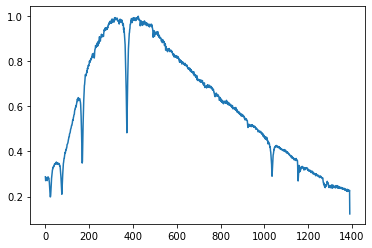

In [84]:
import matplotlib.pyplot as plt
vega_sum = np.sum(vega_light - bias_master, axis=0)
plt.plot(vega_sum/np.max(vega_sum))
len(vega_sum)

In [85]:
# From ijking.ipynb
slope = 2.57550836 * .1 # convert from angstrom to nm.
intercept = 3888.85008 * .1 # convert from angstrom to nm.
def pixels_to_wavelenghts(pixels, slope, intercept):
    '''
    This function converts pixel values to wavelengths using a linear model to be determined by a fit.
    '''
    return slope * pixels + intercept
pixels = np.array(range(len(vega_sum)))
wavelengths = pixels_to_wavelenghts(pixels, slope, intercept)
len(wavelengths)

1391

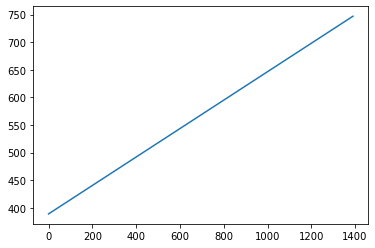

In [86]:
plt.plot(wavelengths)

In [98]:
list_wavelengths = []
for i in wavelengths:
    list_wavelengths.append(i)

list_vega = []
for i in vega_sum:
    k = i/np.max(vega_sum)
    list_vega.append(k)

Text(0, 0.5, 'Relative spectral irradiance $Wm^{-2}nm^{-1}$')

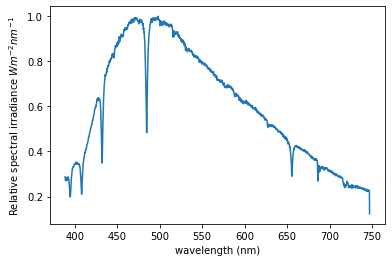

In [90]:
plt.plot(list_wavelengths, list_vega)
plt.xlabel('wavelength (nm)')
plt.ylabel('Relative spectral irradiance $Wm^{-2}nm^{-1}$')

In [106]:
from lmfit import models
import scipy.constants as sc
import astropy.constants as ac

planck_curve = lambda wavelength, temperature: ( ( ( ac.R_sun / ac.au ) ** 2 )  *  ( 2 * sc.Planck * sc.speed_of_light ** 2 ) / ( (wavelength**5) * ( np.exp( ( sc.Planck * sc.speed_of_light) / ( wavelength * sc.k * temperature ) ) - 1 ) ) )
model_curve = models.Model(planck_curve, name='fit')
fit = model_curve.fit(list_vega, wavelength=list_wavelengths, temperature=9600)
fit

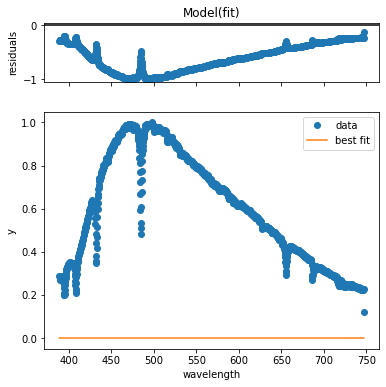

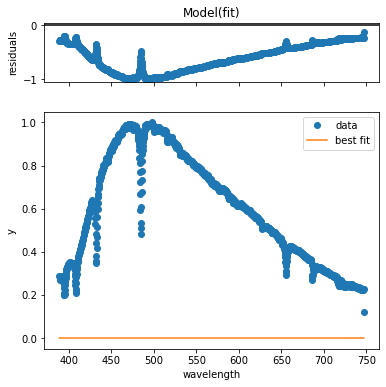

In [102]:
fit.plot()